<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [336]:
!pip install pandas_ta


In [337]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the Stock data only here

In [338]:
# Fetch historical stock data using yfinance
ticker = 'SGC'
start_date , end_date = '2021-01-01' , '2024-02-16'

df = yf.download(ticker, start=start_date, end= end_date)
df['Date'] = df.index
df['Month'] = df.index.month
df['Year'] = df.index.year

# Calculate technical indicators (RSI, MACD, ATR, Bolinger Bands) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.ta.atr(length=14, append=True)
df.ta.bbands(append=True)
# Calculate the 7-day moving average
df['7_day_MA'] = df['Close'].rolling(window=20).mean()

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,Month,Year,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA
Date,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,2021-01-04,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,2021-01-05,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,2021-01-06,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,2021-01-07,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,2021-01-08,1,2021,NaN,NaN,NaN,NaN,NaN,8.837495,9.17,9.502505,7.252023,0.66541,NaN


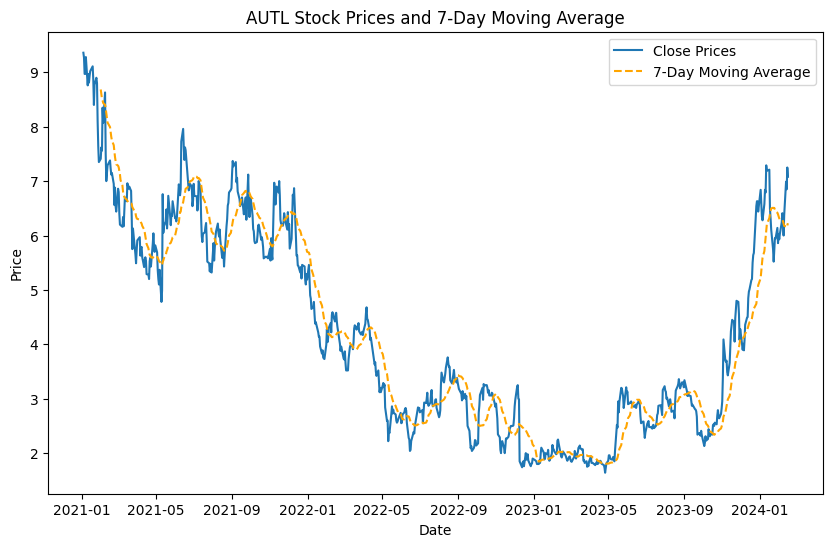

In [339]:
# Plot the closing prices and 7-day moving average
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Prices')
plt.plot(df['7_day_MA'], label='7-Day Moving Average', linestyle='--', color='orange')
plt.title(f'{ticker} Stock Prices and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

##  Add external macro-economic data

In [340]:
# Fetch Federal Funds Rate data from FRED
fed_funds_rate = web.DataReader("FEDFUNDS", "fred", start_date, end_date)
fed_funds_rate['Month'] = fed_funds_rate.index.month
fed_funds_rate['Year'] = fed_funds_rate.index.year

# Merge the daily stock price DataFrame with the monthly Federal Funds Rate DataFrame
df = pd.merge(df, fed_funds_rate[['FEDFUNDS','Month','Year']], left_on=['Year', 'Month'], right_on=['Year', 'Month'], how='left')
# Set 'Date' column as index in the merged DataFrame
df.set_index('Date', inplace=True)

# Drop the 'Original_Index' column if you no longer need it
#df.drop('Date', axis=1, inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume,Month,Year,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,FEDFUNDS
Date,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,1,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,1,2021,NaN,NaN,NaN,NaN,NaN,8.837495,9.17,9.502505,7.252023,0.66541,NaN,0.09


In [341]:
# Fetch VIX data from Yahoo Finance using yfinance
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Rename the 'Adj Close' column to 'VIX' for consistency
vix_data = vix_data.rename(columns={'Adj Close': 'VIX'})

# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, vix_data['VIX'], how='left', left_index=True, right_index=True)
df['Date'] = df.index
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Month,Year,RSI_14,MACD_12_26_9,...,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,FEDFUNDS,VIX,Date
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,26.969999,2021-01-04
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.340000,2021-01-05
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.070000,2021-01-06
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,22.370001,2021-01-07
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,1,2021,NaN,NaN,...,NaN,8.837495,9.17,9.502505,7.252023,0.66541,NaN,0.09,21.559999,2021-01-08


In [342]:
# Fetch Consumer Price Index (CPI) data from FRED
cpi_data = web.DataReader("CPIAUCNS", "fred", start_date, end_date)
# Assuming 'cpi_data' is your DataFrame and 'CPIAUCNS' is the column representing CPI
cpi_data['InflationChange'] = cpi_data['CPIAUCNS'].pct_change() * 100
cpi_data['Month'] = cpi_data.index.month
cpi_data['Year'] = cpi_data.index.year


# Merge the daily stock price DataFrame with the monthly Federal Funds Rate DataFrame
df = pd.merge(df, cpi_data[['CPIAUCNS','Month','Year']], left_on=['Year', 'Month'], right_on=['Year', 'Month'], how='left')
# Set 'Date' column as index in the merged DataFrame
df.set_index('Date', inplace=True)
df['Date'] = df.index

# Drop the 'Original_Index' column if you no longer need it
#df.drop('Date', axis=1, inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume,Month,Year,RSI_14,MACD_12_26_9,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,FEDFUNDS,VIX,CPIAUCNS,Date
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,26.969999,261.582,2021-01-04
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.340000,261.582,2021-01-05
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.070000,261.582,2021-01-06
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,1,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,22.370001,261.582,2021-01-07
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,1,2021,NaN,NaN,...,8.837495,9.17,9.502505,7.252023,0.66541,NaN,0.09,21.559999,261.582,2021-01-08


In [343]:
# Fetch Nonfarm Payrolls data from FRED using pandas_datareader
nfp_data = web.DataReader("PAYEMS", "fred", start_date, end_date)
# Rename the column to 'Nonfarm Payrolls' for consistency
nfp_data = nfp_data.rename(columns={'PAYEMS': 'Nonfarm Payrolls'})
nfp_data['Month'] = nfp_data.index.month
nfp_data['Year'] = nfp_data.index.year

# Merge the daily stock price DataFrame with the monthly Federal Funds Rate DataFrame
df = pd.merge(df, nfp_data[['Nonfarm Payrolls','Month','Year']], left_on=['Year', 'Month'], right_on=['Year', 'Month'], how='left')
# Set 'Date' column as index in the merged DataFrame
df.set_index('Date', inplace=True)
df['Date'] = df.index

# Drop the 'Original_Index' column if you no longer need it
df.drop('Date', axis=1, inplace=True)
# Drop the additional columns 'Month', 'Year', if you don't need them anymore
df.drop(['Month', 'Year'], axis=1, inplace=True)


df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,FEDFUNDS,VIX,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,26.969999,261.582,142916.0
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.340000,261.582,142916.0
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.070000,261.582,142916.0
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,22.370001,261.582,142916.0
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,NaN,NaN,NaN,NaN,...,8.837495,9.17,9.502505,7.252023,0.66541,NaN,0.09,21.559999,261.582,142916.0


In [344]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 10

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,7_day_MA,FEDFUNDS,VIX,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,8.94,9.51,8.674,9.36,9.36,105600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,26.969999,261.582,142916.0
2021-01-05,9.46,9.66,9.100,9.27,9.27,150200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.340000,261.582,142916.0
2021-01-06,9.26,9.26,8.650,8.97,8.97,203900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,25.070000,261.582,142916.0
2021-01-07,9.00,9.98,8.860,8.97,8.97,2110500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.09,22.370001,261.582,142916.0
2021-01-08,9.11,9.35,8.910,9.28,9.28,284800,NaN,NaN,NaN,NaN,...,8.837495,9.17,9.502505,7.252023,0.66541,NaN,0.09,21.559999,261.582,142916.0


In [345]:
# Columns on the dataframe
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATRr_14',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0',
       '7_day_MA', 'FEDFUNDS', 'VIX', 'CPIAUCNS', 'Nonfarm Payrolls'],
      dtype='object')

In [346]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
#features = ['Close', 'Volume']
#features = ['Close', 'Volume','RSI_14','ATRr_14','VIX']
features = ['Close', 'Volume','RSI_14','MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14','VIX' ]
#features = ['Close', 'Volume','VIX', 'ATRr_14']

#features = ['Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14', 'VIX', 'FEDFUNDS', 'CPIAUCNS']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')

# Columns to be scaled (excluding Federal Funds Rate)
#columns_to_scale = ['Open', 'Volume', 'RSI_14', 'VIX']

train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,VIX
Date,,,,,,,,
2021-02-22,6.95,1467200,36.060427,-0.501775,-0.003625,-0.498150,0.570238,23.450001
2021-02-23,6.56,1075500,32.183539,-0.530556,-0.025925,-0.504631,0.591971,23.110001
2021-02-24,6.88,845700,38.067150,-0.521531,-0.013521,-0.508011,0.581011,21.340000
2021-02-25,6.54,1144300,34.629450,-0.535640,-0.022104,-0.513537,0.580933,28.889999
2021-02-26,6.44,996900,33.666463,-0.548567,-0.028024,-0.520543,0.576892,27.950001


### Feature Scaling

In [347]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 742



array([[0.84018984, 0.03482841, 0.25156041, 0.03748787, 0.56762297,
        0.01938192, 0.95664703, 0.46677607],
       [0.778481  , 0.02544195, 0.19077126, 0.01443011, 0.51127629,
        0.01377229, 1.        , 0.45283021],
       [0.82911394, 0.01993516, 0.28302558, 0.02165981, 0.5426194 ,
        0.01084672, 0.97813633, 0.3802297 ],
       [0.77531645, 0.02709063, 0.22912285, 0.01035647, 0.52093185,
        0.00606394, 0.97798156, 0.68990972],
       [0.75949368, 0.02355842, 0.21402333, 0.        , 0.50597093,
        0.        , 0.96991949, 0.65135358]])

### Creating a data structure with 180 timesteps and 1 output

In [348]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [349]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [350]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (682, 60, 8)


## Part 2 - Building and Training the LSTM

### Initialising the RNN

In [351]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [352]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [353]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [354]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [355]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [356]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [357]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [358]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
22/22 [==============================] - 11s 111ms/step - loss: 0.0551
Epoch 2/100
22/22 [==============================] - 3s 152ms/step - loss: 0.0144
Epoch 3/100
22/22 [==============================] - 2s 109ms/step - loss: 0.0107
Epoch 4/100
22/22 [==============================] - 2s 109ms/step - loss: 0.0108
Epoch 5/100
22/22 [==============================] - 2s 108ms/step - loss: 0.0091
Epoch 6/100
22/22 [==============================] - 3s 123ms/step - loss: 0.0084
Epoch 7/100
22/22 [==============================] - 3s 135ms/step - loss: 0.0081
Epoch 8/100
22/22 [==============================] - 2s 109ms/step - loss: 0.0076
Epoch 9/100
22/22 [==============================] - 2s 109ms/step - loss: 0.0076
Epoch 10/100
22/22 [==============================] - 2s 112ms/step - loss: 0.0080
Epoch 11/100
22/22 [==============================] - 3s 149ms/step - loss: 0.0074
Epoch 12/100
22/22 [==============================] - 3s 115ms/step - loss: 0.0071
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [359]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,VIX
Date,,,,,,,,
2024-02-02,6.03,909600,50.824542,0.049036,-0.098808,0.147845,0.480283,13.85
2024-02-05,6.24,625700,54.486444,0.060525,-0.069856,0.130381,0.483548,13.67
2024-02-06,6.41,594800,57.261028,0.082397,-0.038387,0.120784,0.483295,13.06
2024-02-07,6.32,376200,55.337694,0.091415,-0.023495,0.114910,0.471631,12.83
2024-02-08,6.00,12049700,49.031536,0.071912,-0.034399,0.106311,0.505086,12.79


In [360]:
# Plot a line chart using Plotly Express
#fig = px.line(dataset_test, x=dataset_test.index, y='7_day_MA', title='7-Day Moving Average Stock Price Over Time')
fig = px.line(dataset_test, x=dataset_test.index, y='Close', title='Stock Price Over Time')
# Show the plot
fig.show()

In [361]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[6.03000021],
       [6.23999977],
       [6.40999985],
       [6.32000017],
       [6.        ]])

In [362]:
len(dataset_test)

10

### Getting the predicted stock price

In [363]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (70, 8)

Shape of inputs after reshaping: (70, 8)
Shape of X_test before reshaping: (10, 60, 8)

Shape of X_test after reshaping: (10, 60, 8)
1/1 [==============================] - 2s 2s/step


### Visualising the results

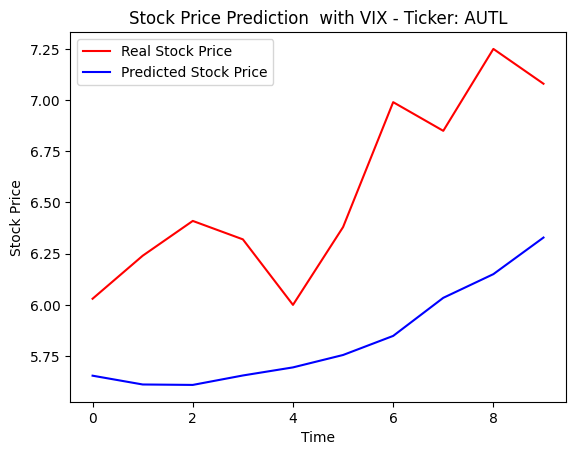

In [364]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction  with VIX - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Monte- Carlo Simulation

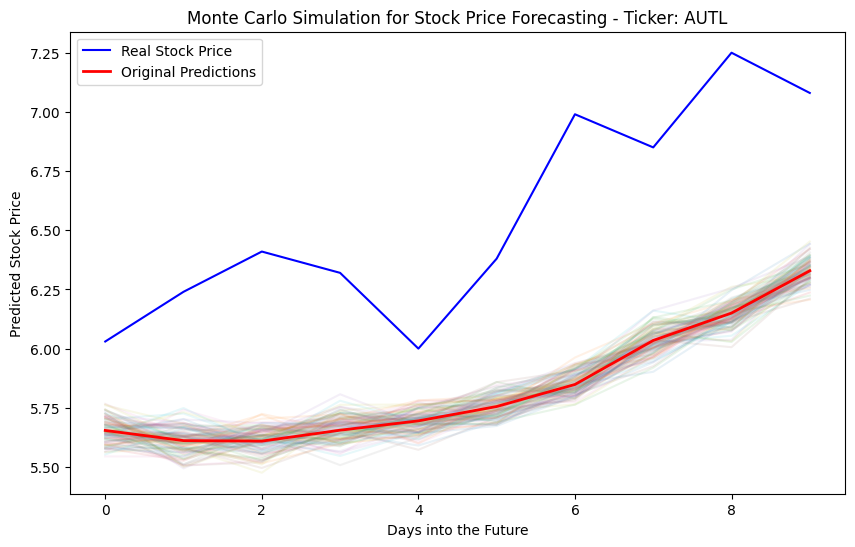

In [365]:
# Generate dummy features for the next few day

# Number of simulations for the Monte Carlo simulation
num_simulations = 100

# Create an array to store simulation results
simulation_results = np.zeros((num_simulations, len(model_predictions)))

# Perform Monte Carlo simulation
for i in range(num_simulations):
    # Introduce random noise to the model predictions
    noise = np.random.normal(0, 0.05, len(model_predictions))  # Adjust the standard deviation as needed
    simulated_predictions = model_predictions + noise

    # Store the simulated predictions in the results array
    simulation_results[i, :] = simulated_predictions

# Plot the Monte Carlo simulation results

plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(np.arange(len(model_predictions)), simulation_results[i, :], linestyle='-', marker='', alpha=0.1)

# Plot the original predictions
plt.plot(real_stock_price, color = 'blue', label = 'Real Stock Price')
plt.plot(np.arange(len(model_predictions)), model_predictions, label='Original Predictions', color='red', linewidth=2)

plt.title(f'Monte Carlo Simulation for Stock Price Forecasting - Ticker: {ticker}')
plt.xlabel('Days into the Future')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.show()
